## **Now, why is the python version different from the sys.version?**: sys.version gives the IPy kernel version, 

In [1]:
# This gives the REPL python version, if I start the notebook from conda env == base, then
#  it's the base env 's python version, 
!python --version

Python 3.8.13


In [2]:
# this gives the ipython kernel python version, if I choose conda(base) as the kernel, then it shows the conda(base) 
# python version
import sys
print(sys.version)

3.8.13 (default, Mar 28 2022, 06:59:08) [MSC v.1916 64 bit (AMD64)]


__As a test, only installed TF in `remoteCom` environment__

In [9]:
import tensorflow as tf

In [10]:
!jupyter kernelspec list

Available kernels:
  conda-base         C:\Users\lizhou\AppData\Roaming\jupyter\kernels\conda-base
  conda-remotecom    C:\Users\lizhou\AppData\Roaming\jupyter\kernels\conda-remotecom
  python3            C:\Users\lizhou\AppData\Roaming\jupyter\kernels\python3


In [11]:
# !jupyter kernelspec list --json

**"C:\\Users\\lizhou\\Anaconda3\\python.exe",** gives the binary python file

In [12]:
!where python

C:\Users\lizhou\Anaconda3\envs\remoteCom\python.exe
C:\Users\lizhou\Anaconda3\python.exe
C:\Users\lizhou\AppData\Local\Microsoft\WindowsApps\python.exe


In [13]:
!C:\Users\lizhou\Anaconda3\envs\remoteCom\python.exe --version

Python 3.10.4


In [14]:
!C:\Users\lizhou\Anaconda3\python.exe --version

Python 3.9.7


## Load data & packages

In [15]:
# input dataset
input_file = "../data/all_combined_training.csv"
validation_file = "../data/all_combined_validation.csv"
model_root= "../models/"
data_root="../data/"
fig_root='../figs/'
package_root='../packages/'
root='../'

DEBUG_MODE = True

In [61]:
%%capture
import os
import sys
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
import numpy as np
import pandas as pd

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import pickle
# joblib still saves model in .pickle files
from joblib import dump, load
import xgboost as xgb

sns.set()
plt.style.use('bmh')

# There is a slight chance that I might have to run the following two lines for the local package to work
# import sys
# sys.path.insert(0, '..')

from Preps import prep
Preprocessing = prep.Preprocessing()

In [17]:
# load data
df = pd.read_csv(input_file, index_col = 0)
dfc=df.copy()
dfc['datetime'] = pd.to_datetime(dfc[['year', 'month', 'day', 'hour']])
dfc['date'] = pd.to_datetime(dfc[['year', 'month', 'day']])
dfc['kw_cap'] = dfc['Kw']/df['population']
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),datetime,date,kw_cap
170302,2014,6,10,22,1995.181818,58.10006,-68.40612,2754,3291.582628,9.708643,2014-06-10 22:00:00,2014-06-10,0.724467
210752,2013,1,22,7,472.507167,60.01732,-70.02754,567,582.943444,-26.424567,2013-01-22 07:00:00,2013-01-22,0.833346


## Hourly resolution

In [18]:
list_of_df = Preprocessing.load_dframes(df_name='df', prop="_processed",data_root=data_root)

for i in range(0,9):
    vars()['df'+str(i+1)+"_processed"] = list_of_df[i]

# ensure 
Preprocessing.show_shape([df1_processed, df2_processed, df9_processed])

,num_of_rows,num_of_cols
dataframe 0,26280,13
dataframe 1,26280,13
dataframe 2,26280,13


In [19]:
df1_processed.columns

Index(['year', 'month', 'day', 'hour', 'Kw', 'lat', 'lon', 'population',
       'annual_peak_load', 'Temp (°C)', 'date', 'kw_cap', 'datetime'],
      dtype='object')

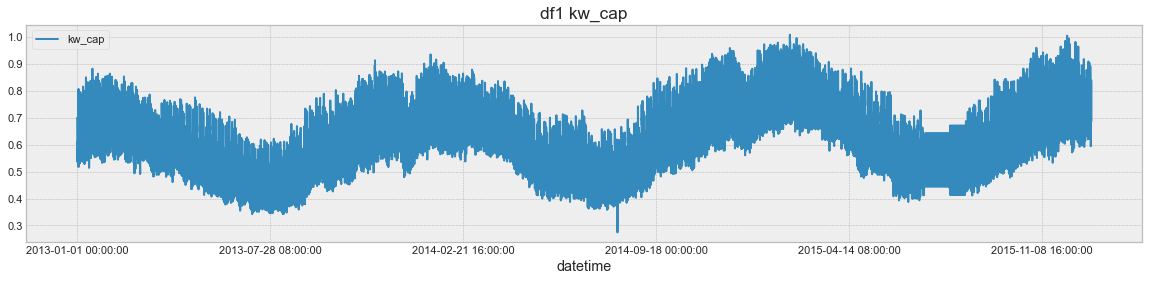

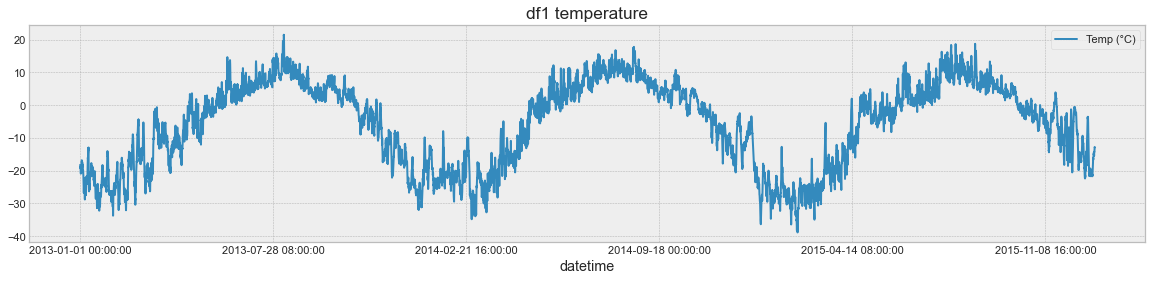

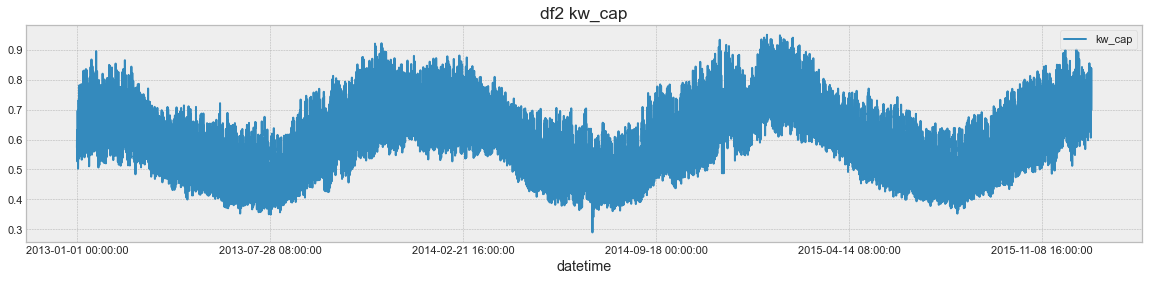

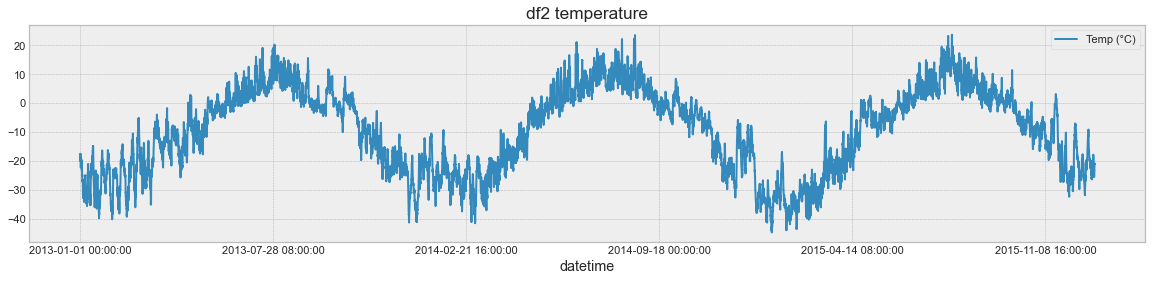

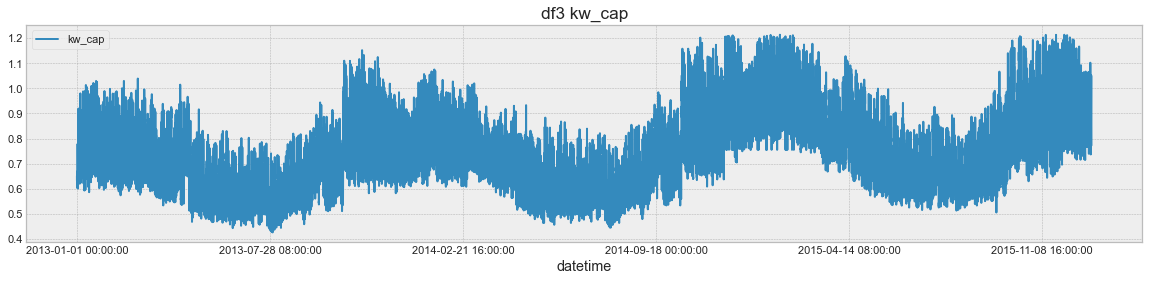

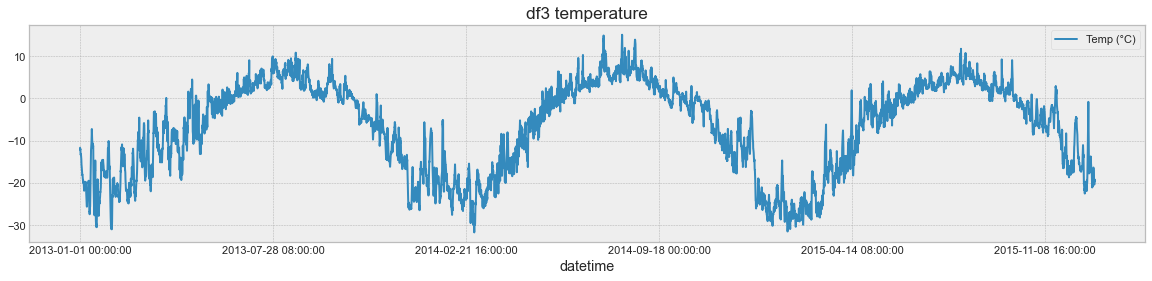

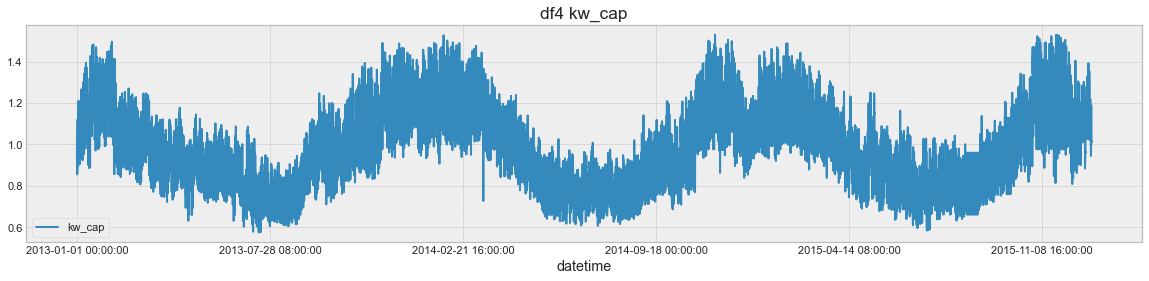

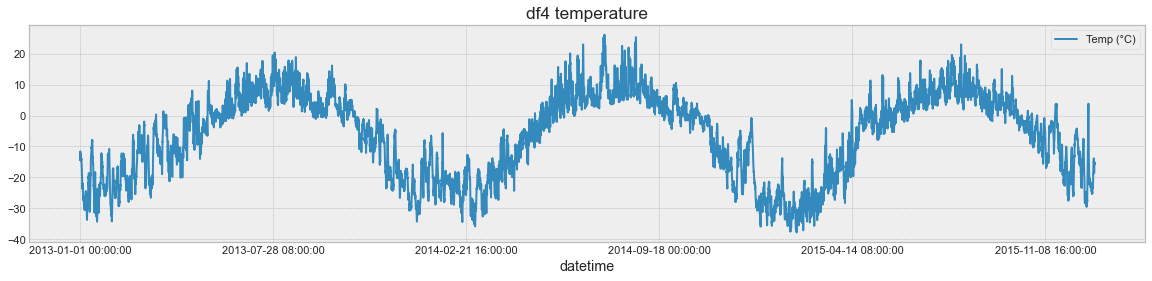

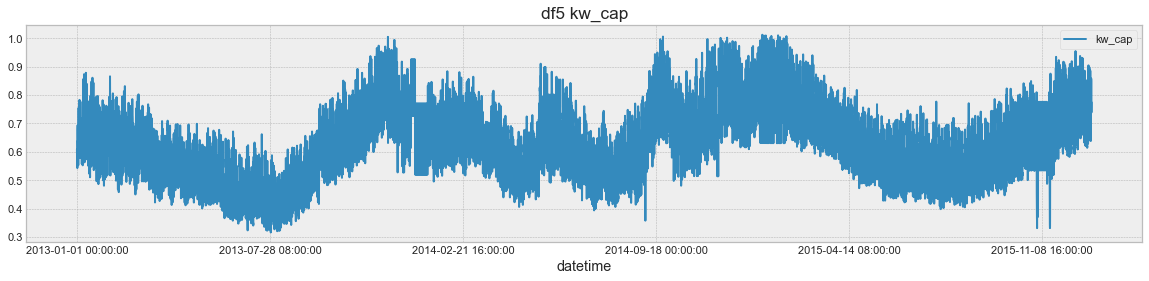

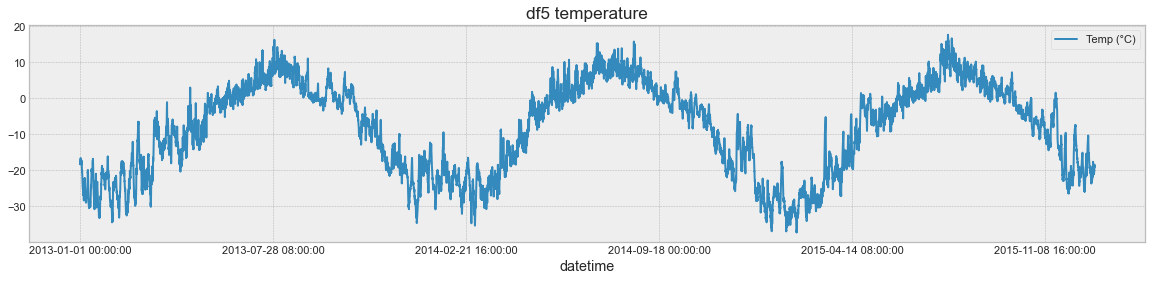

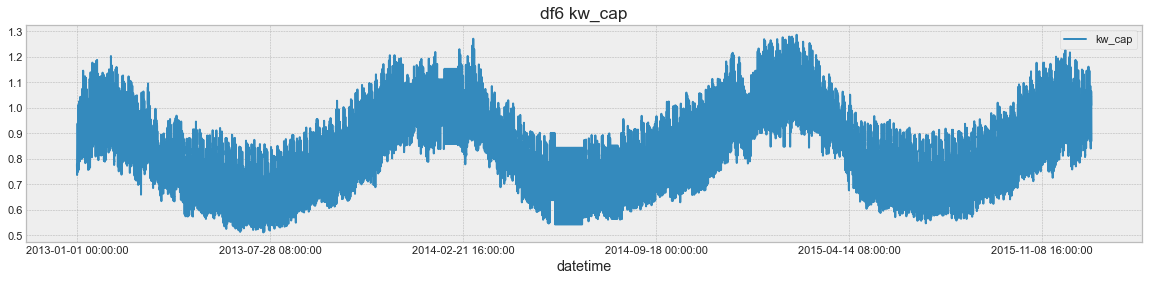

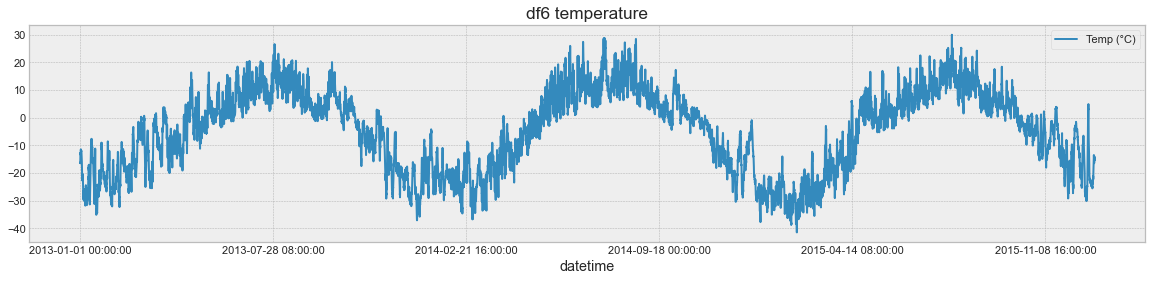

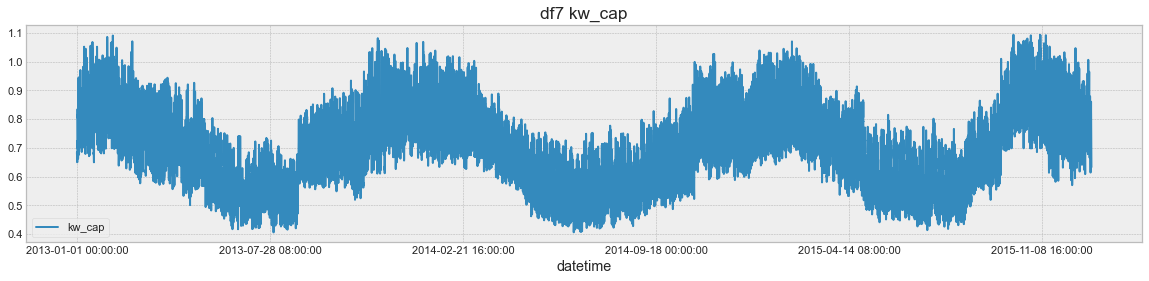

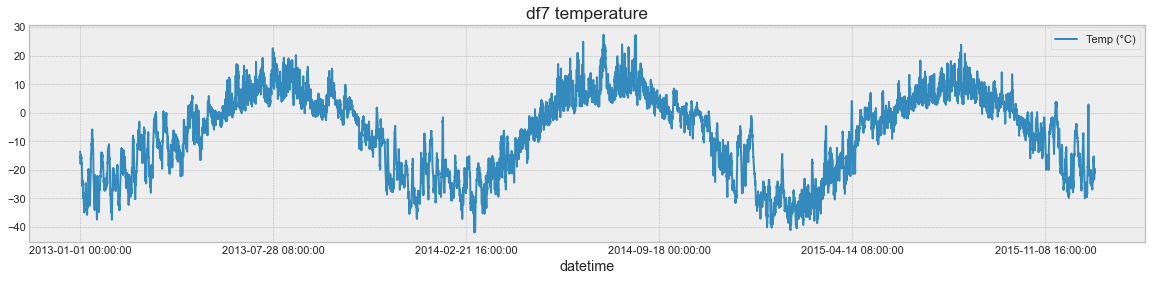

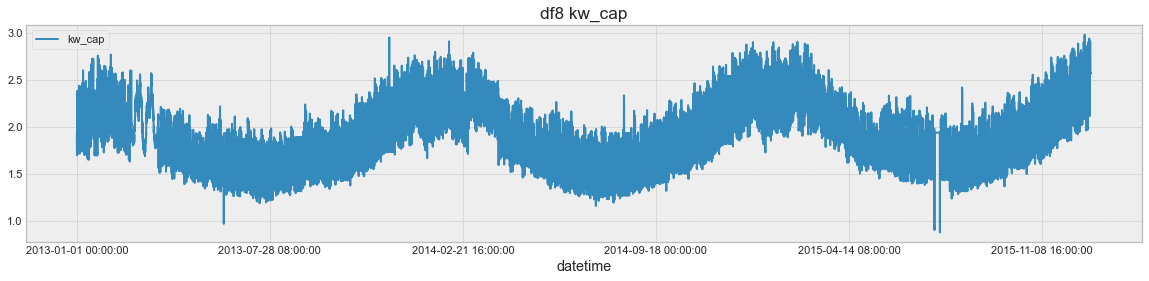

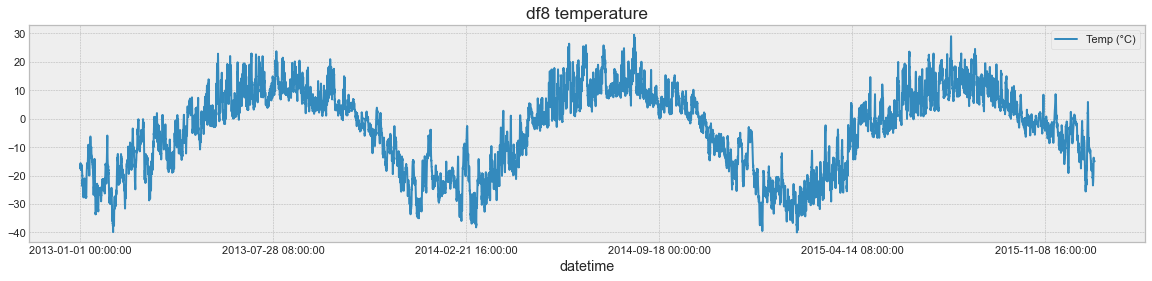

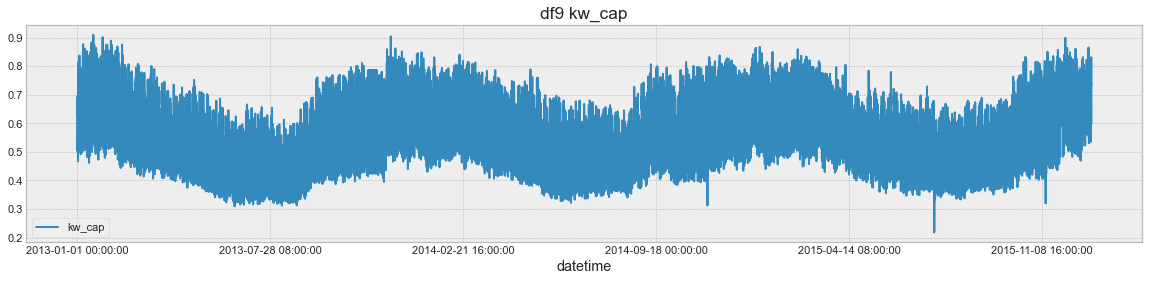

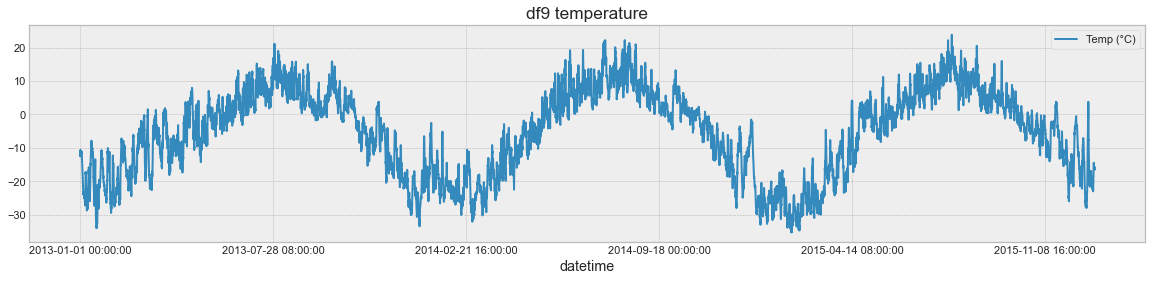

In [20]:
Preprocessing.plot_dfs(list_of_df)

## Scale and standardize the data

__The `temperature` and `kw_cap` seem *VERY* correlated__: but let's transform the two series before calculating the correlation. How about we scale them to `[0,1]`? 

In [21]:
# scale_series(cols=[56 , 'Temp (°C)'], cols_scaler_range=[(0,1), (0, 0.7)], DEBUG_MODE=False)
list_of_scaled_df = Preprocessing.scale_series(list_of_df, 
                                               cols=['kw_cap', 'Temp (°C)'], 
                                               cols_scaler_range=[(0,1), (0, 0.7)], 
                                               DEBUG_MODE=False)
for i in range(len(list_of_scaled_df)):
    vars()['df'+str(i+1)+'_scaled'] = list_of_scaled_df[i]

df6_scaled

,kw_cap,Temp (°C)
0,0.343768,0.246795
1,0.337212,0.247528
2,0.323786,0.245084
3,0.303804,0.263264
4,0.290383,0.267925
...,...,...
26275,0.602069,0.261174
26276,0.557893,0.259547
26277,0.515513,0.255094
26278,0.463689,0.257842


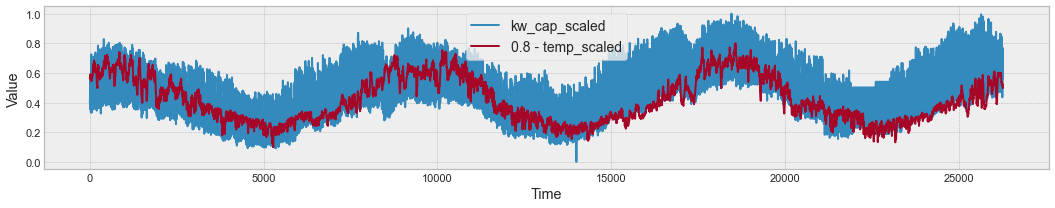

In [22]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

plt.figure(figsize=(18, 3))
plot_series(range(len(df1_scaled.kw_cap)), df1_scaled.kw_cap, label="kw_cap_scaled")
plot_series(range(len(df1_scaled['Temp (°C)'])), 0.8-df1_scaled['Temp (°C)'], label=f"0.8 - temp_scaled")

__Standardize the data__

In [23]:
list_of_std_df= Preprocessing.standardize_series(list_of_df[:3], 
                                 cols=['kw_cap', 'Temp (°C)'], 
                                 DEBUG_MODE=True)

for i in range(len(list_of_std_df)):
    vars()['df'+str(i+1)+'_stdard'] = list_of_std_df[i]

Mean: 0.631547, StandardDeviation: 0.126836
Mean: -5.730700, StandardDeviation: 12.748533

Mean: 0.613737, StandardDeviation: 0.112319
Mean: -9.438642, StandardDeviation: 14.322398

Mean: 0.754588, StandardDeviation: 0.151555
Mean: -6.759384, StandardDeviation: 10.533940



__Sanity check__: verify that the data mean and std are `0` and `1`

In [24]:
dd = df2_stdard['kw_cap'].values.reshape(len(df2_stdard),1)
scaler = StandardScaler()
scaler = scaler.fit(dd)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))

Mean: -0.000000, StandardDeviation: 1.000000


## Let's find the correlation between two variables

In [25]:
corr = df1_processed[['kw_cap','Temp (°C)','year','month','day','hour']].corr(method ='pearson')
corr

,kw_cap,Temp (°C),year,month,day,hour
kw_cap,1.000000,-0.559777,2.406319e-01,-7.846806e-02,-1.844179e-02,4.397565e-01
Temp (°C),-0.559777,1.000000,-2.928708e-02,4.942568e-01,2.610159e-02,3.644995e-02
year,0.240632,-0.029287,1.000000e+00,-5.445272e-13,-1.187103e-13,-2.534997e-15
month,-0.078468,0.494257,-5.445272e-13,1.000000e+00,1.189318e-02,-9.789197e-16
day,-0.018442,0.026102,-1.187103e-13,1.189318e-02,1.000000e+00,-9.946543e-17
hour,0.439757,0.036450,-2.534997e-15,-9.789197e-16,-9.946543e-17,1.000000e+00


* kw_cap ~ Temp
* kw_cap ~ year
* kw_cap ~ hour

by influence on kw_cap: Temp > hour > year

__Correlation is the same regardless of the standardization__

In [26]:
df1_stdard.corr()

,kw_cap,Temp (°C)
kw_cap,1.000000,-0.559777
Temp (°C),-0.559777,1.000000


C:\Users\lizhou\Anaconda3\envs\remoteCom\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


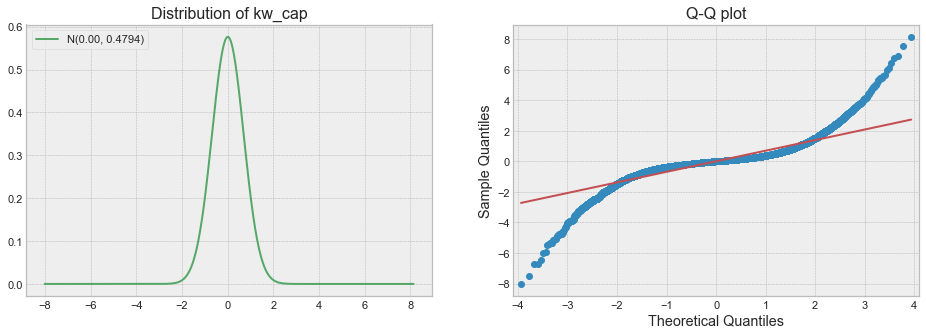

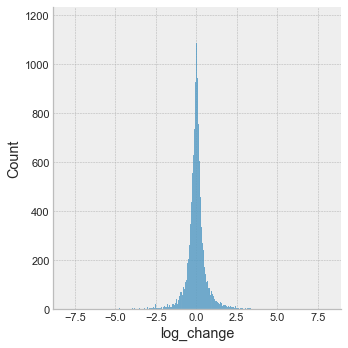

In [27]:
import scipy.stats as scs

d_series = df1_stdard['kw_cap']
df1_processed['log_change'] = np.log(d_series/d_series.shift(1))
Preprocessing.plot_QQ(df1_processed, 'log_change')

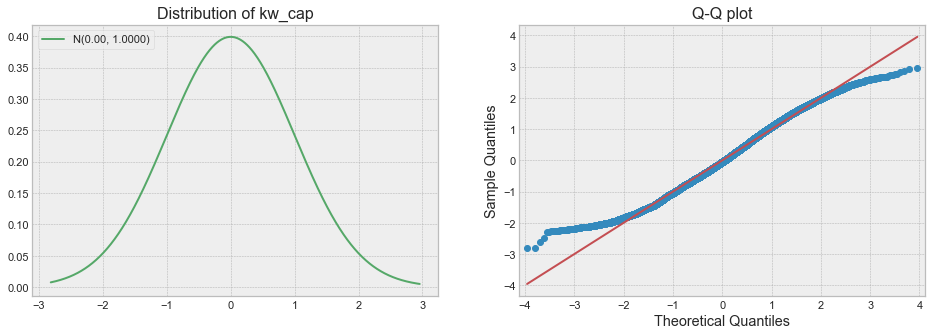

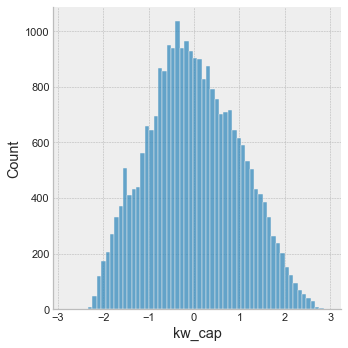

In [28]:
Preprocessing.plot_QQ(df1_stdard, 'kw_cap')

## Scatter plot

<AxesSubplot:xlabel='kw_cap', ylabel='annual_peak_load'>

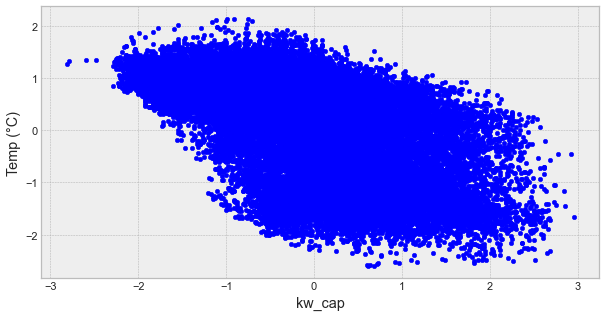

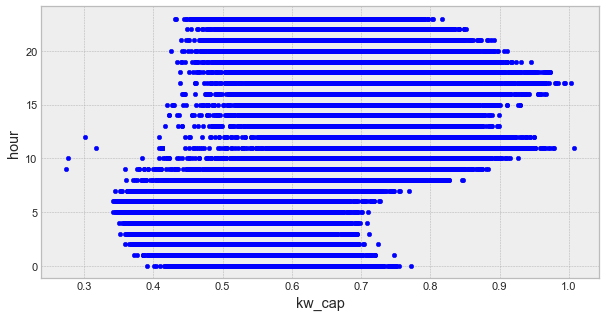

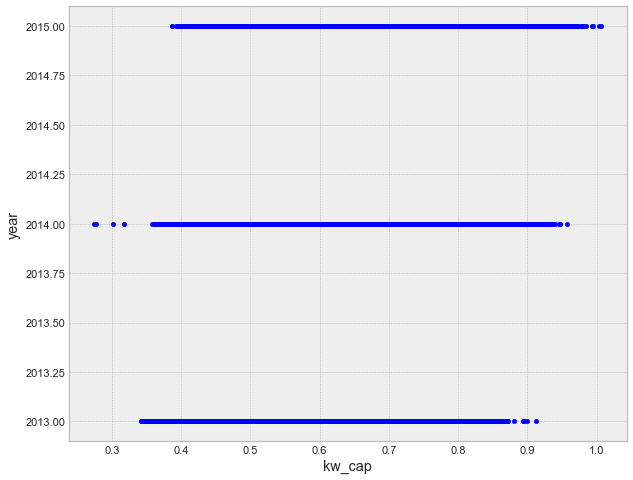

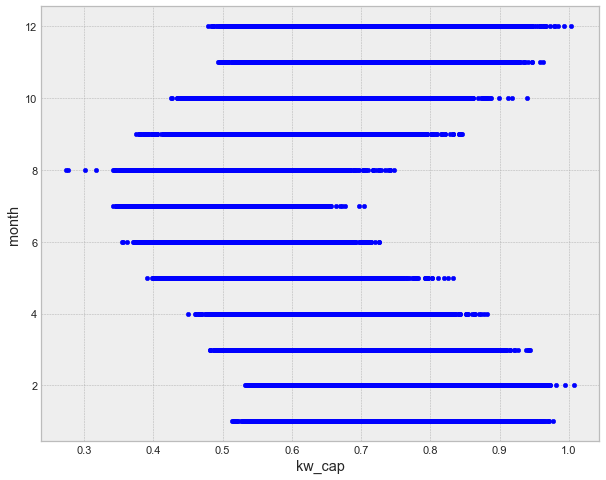

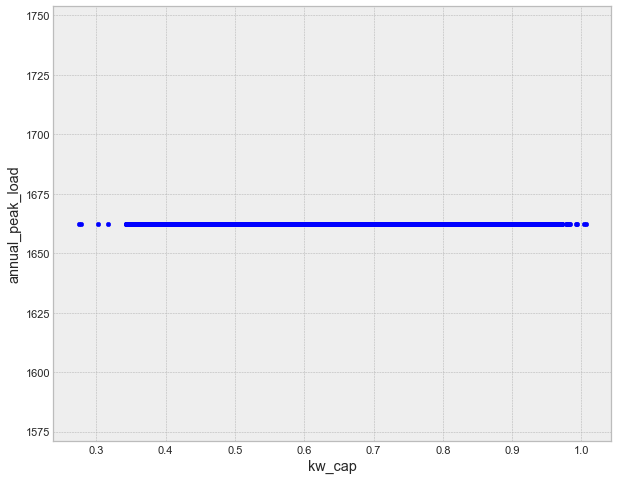

In [55]:
df1_stdard.plot(x='kw_cap', y='Temp (°C)', kind='scatter', figsize=(10, 5))
df1_processed.plot(x='kw_cap', y='hour', kind='scatter', figsize=(10, 5))
df1_processed.plot(x='kw_cap', y='year', kind='scatter', figsize=(10, 8))
df1_processed.plot(x='kw_cap', y='month', kind='scatter', figsize=(10, 8))
df1_processed.plot(x='kw_cap', y='annual_peak_load', kind='scatter', figsize=(10, 8))

## XGB Predictions

In [54]:
df1_processed.columns
# df1_processed.hour.value_counts()

Index(['year', 'month', 'day', 'hour', 'Kw', 'lat', 'lon', 'population',
       'annual_peak_load', 'Temp (°C)', 'date', 'kw_cap', 'datetime',
       'log_change'],
      dtype='object')

In [57]:
train_data = df1_processed[:int(df1_processed.shape[0]*0.8)]
test_data = df1_processed[int(df1_processed.shape[0]*0.8):]

X_train = train_data.copy().drop(columns=['kw_cap', 'lat', 'lon', 'population',
                                          'annual_peak_load','datetime','log_change', 'Kw', 'date'])    
X_test = test_data.copy().drop(columns=['kw_cap', 'lat', 'lon', 'population', 
                                        'annual_peak_load','datetime','log_change', 'Kw', 'date'])    

output_cols=['kw_cap']
y_train = train_data.copy()[output_cols]
y_test = test_data.copy()[output_cols]

In [59]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 100, seed = 123)
  
xgb_r.fit(X_train, y_train, 
        #  eval_set=[(X_train, y_train),(X_test, y_test)],
         eval_metric='mae')

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, ...)

In [62]:
# Predictions on the train dataset
train_pred = xgb_r.predict(X_train)
# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_pred = xgb_r.predict(X_test)
# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("Train RMSE : % f" %(train_rmse))
print("Test RMSE : % f" %(test_rmse))

Train RMSE :  0.022468
Test RMSE :  0.052132


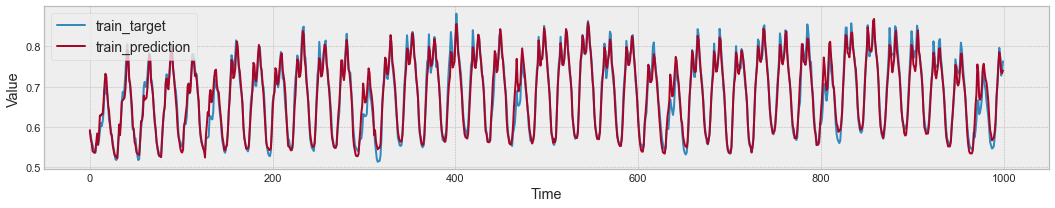

In [79]:
plt.figure(figsize=(18, 3))
target_s = pd.Series(y_train.kw_cap)[:1000]
pred_s = pd.Series(train_pred)[:1000]
plot_series(range(len(target_s)), target_s, label="train_target")
plot_series(range(len(pred_s)), pred_s, label=f"train_prediction")

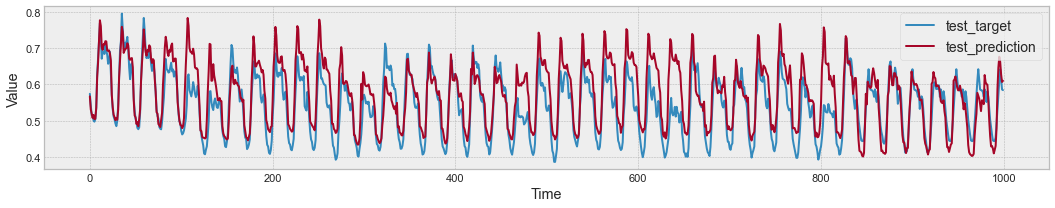

In [80]:
plt.figure(figsize=(18, 3))
target_s = pd.Series(y_test.kw_cap)[:1000]
pred_s = pd.Series(test_pred)[:1000]
plot_series(range(len(target_s)), target_s, label="test_target")
plot_series(range(len(pred_s)), pred_s, label=f"test_prediction")

In [94]:
X_train['Temp (°C) shift 1'] = X_train['Temp (°C)'].shift(periods=1, fill_value=X_train['Temp (°C)'].mean())
X_train['Temp (°C) shift 3'] = X_train['Temp (°C)'].shift(periods=3, fill_value=X_train['Temp (°C)'].mean())
X_train['Temp (°C) shift 5'] = X_train['Temp (°C)'].shift(periods=5, fill_value=X_train['Temp (°C)'].mean())
X_train['Temp (°C) shift 7'] = X_train['Temp (°C)'].shift(periods=7, fill_value=X_train['Temp (°C)'].mean())

X_test['Temp (°C) shift 1'] = X_test['Temp (°C)'].shift(periods=1, fill_value=X_test['Temp (°C)'].mean())
X_test['Temp (°C) shift 3'] = X_test['Temp (°C)'].shift(periods=3, fill_value=X_test['Temp (°C)'].mean())
X_test['Temp (°C) shift 5'] = X_test['Temp (°C)'].shift(periods=5, fill_value=X_test['Temp (°C)'].mean())
X_test['Temp (°C) shift 7'] = X_test['Temp (°C)'].shift(periods=7, fill_value=X_test['Temp (°C)'].mean())

X_test.head()
X_train.head()

,year,month,day,hour,Temp (°C),Temp (°C) shift 1,Temp (°C) shift 2,Temp (°C) shift 3,Temp (°C) shift 5,Temp (°C) shift 7
0,2013,1,1,0,-18.211905,-7.413417,-7.413417,-7.413417,-7.413417,-7.413417
1,2013,1,1,1,-18.678336,-18.211905,-7.413417,-7.413417,-7.413417,-7.413417
2,2013,1,1,2,-18.978430,-18.678336,-18.211905,-7.413417,-7.413417,-7.413417
3,2013,1,1,3,-18.901541,-18.978430,-18.678336,-18.211905,-7.413417,-7.413417
4,2013,1,1,4,-19.094290,-18.901541,-18.978430,-18.678336,-7.413417,-7.413417


In [95]:
xgb_r.fit(X_train, y_train, 
        #  eval_set=[(X_train, y_train),(X_test, y_test)],
         eval_metric='mae')
# Predictions on the train dataset
train_pred = xgb_r.predict(X_train)
# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
test_pred = xgb_r.predict(X_test)
# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("Train RMSE : % f" %(train_rmse))
print("Test RMSE : % f" %(test_rmse))

C:\Users\lizhou\Anaconda3\envs\remoteCom\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


Train RMSE :  0.021034
Test RMSE :  0.051253


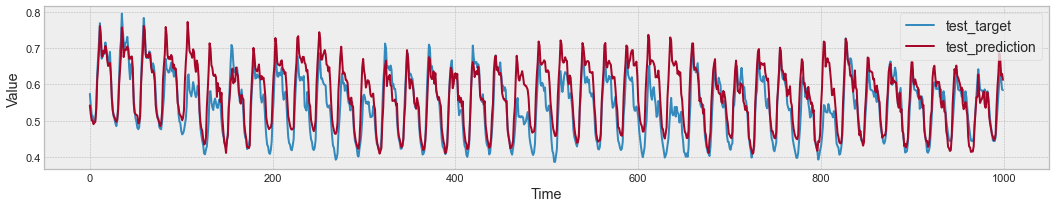

In [96]:
plt.figure(figsize=(18, 3))
target_s = pd.Series(y_test.kw_cap)[:1000]
pred_s = pd.Series(test_pred)[:1000]
plot_series(range(len(target_s)), target_s, label="test_target")
plot_series(range(len(pred_s)), pred_s, label=f"test_prediction")